In [2]:
import sys
print("Python Version:", sys.version)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns
pd.set_option('display.max_rows', 500)
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

Python Version: 3.7.6 (default, Jan  8 2020, 20:23:39) [MSC v.1916 64 bit (AMD64)]


In [4]:
df_turns_no_outlier = pd.read_pickle('Cleaned_Working_Dataframe.pkl')

# Bringing in Census Data and Various Chart Work

In [439]:
#Read in pickled working dataframe to start.
df_turns_no_outlier.to_pickle('Cleaned_Working_Dataframe.pkl')

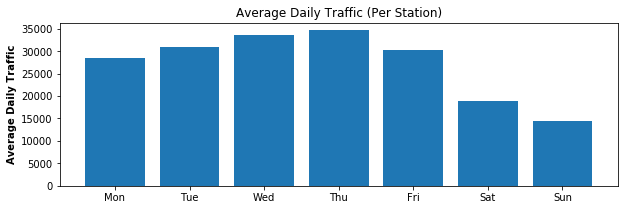

In [411]:
#Create a color palet to match NYC subway colors
clrs = ['#0039A6', '#FF6319', '#996633', '#6CBE45', '#A7A9AC', '#FCCC0A',
        '#808183', '#EE352E', '#00933C', '#B933AD']

# Set order for days of the week variable.
df_turns_no_outlier['Weekday'] = pd.Categorical(df_turns_no_outlier['Weekday'], categories=
    ['Mon','Tue','Wed','Thu','Fri','Sat', 'Sun'],
    ordered=True)


#plot average traffic per day
plt.figure(figsize=(10,3))
plt.bar(x=df_turns_no_outlier.groupby(['DATE','Weekday'],as_index=False).mean().Weekday,height= df_turns_no_outlier.groupby(['DATE','Weekday'],as_index=False).mean().Total_Traffic_x)
plt.ylabel('Average Daily Traffic',fontsize = 10, weight = 'bold')
plt.title('Average Daily Traffic (Per Station)')
plt.savefig('average_daily.png')

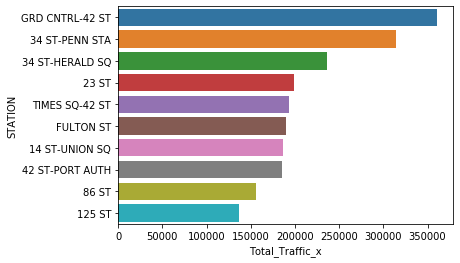

In [391]:
# Create chart of stations with the highest average daily traffic on weekdays.
df_filt_weekdays = df_turns_no_outlier[df_turns_no_outlier.Weekday.isin(['Mon','Tue','Wed','Thu','Fri'])]
df_filt_weekdays = df_filt_weekdays.groupby(['STATION'], as_index=False).mean()
df_filt_weekdays = df_filt_weekdays.sort_values('Total_Traffic_x', ascending=False).head(10)
sns.barplot(x ='Total_Traffic_x',y='STATION',data=df_filt_weekdays, orient='h')

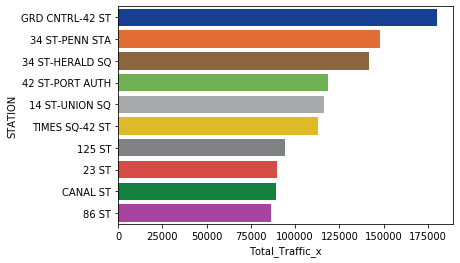

In [409]:
# Create chart of stations with the highest average daily traffic on weekends.
df_filt_weekend = df_turns_no_outlier[df_turns_no_outlier.Weekday.isin(['Sat','Sun'])]
df_filt_weekend = df_filt_weekend.groupby(['STATION'], as_index=False).mean()
df_filt_weekend = df_filt_weekend.sort_values('Total_Traffic_x', ascending=False).head(10)
sns.barplot(x ='Total_Traffic_x',y='STATION',data=df_filt_weekend, orient='h', palette=clrs)

# Weekday Map (Traffic and Scoring)

In [338]:
import folium
from folium.plugins import MarkerCluster

In [339]:
from colour import Color
red = Color("red")
colors = list(red.range_to(Color("green"),100))

In [424]:
#Make Map for Weekdays
df_filt_weekdays = df_turns_no_outlier[df_turns_no_outlier.Weekday.isin(['Mon','Tue','Wed','Thu','Fri'])]
df_filt_weekdays = df_filt_weekdays.groupby(['STATION'], as_index=False).mean()


# bring in Census data that was created with R script.
cen_dat = pd.read_csv('geocoded_cen_dat.csv')

# Identify the columns from census data that we need to keep.
cen_vars=['STATION',
          'LAT',
          'LON',
          'p_f_pop',
          'p_emp_info',
          'p_emp_prof',
          'p_75_100k',
          'p_over_100k']

# Add census Data to Weekday Station Data with a left join on station
df_filt_weekdays_cen=pd.merge(df_filt_weekdays, 
                              cen_dat[cen_vars],  
                              how='left', 
                              left_on=['STATION'], 
                              right_on = ['STATION']
                             )

# Because census data includes division stations become duplicated. We can just remove the duplicates.
df_filt_weekdays_cen =df_filt_weekdays_cen.drop_duplicates(['STATION'])
df_filt_weekdays_cen.sort_values('Total_Traffic_x', ascending=False).head(100)

# Convert Census and Traffic Data to a percentile ranking and multiply by 100. Stations with the highest values for each
# Variable with have a score of 100 and the lowest will recieve a 0. This will help make the variables easier to combine
# into a score in the future.

df_filt_weekdays_cen['Traffic_Rank'] = df_filt_weekdays_cen['Total_Traffic_x'].rank(ascending=True,pct=True)*100
df_filt_weekdays_cen['p_f_pop_Rank'] = df_filt_weekdays_cen['p_f_pop'].rank(ascending=True,pct=True)*100
df_filt_weekdays_cen['p_emp_info_Rank'] = df_filt_weekdays_cen['p_emp_info'].rank(ascending=True,pct=True)*100
df_filt_weekdays_cen['p_emp_prof_Rank'] = df_filt_weekdays_cen['p_emp_prof'].rank(ascending=True,pct=True)*100
df_filt_weekdays_cen['p_75_100k_Rank'] = df_filt_weekdays_cen['p_75_100k'].rank(ascending=True,pct=True)*100
df_filt_weekdays_cen['p_over_100k_Rank'] = df_filt_weekdays_cen['p_over_100k'].rank(ascending=True,pct=True)*100

# Calculate a Recommendation Score using custom weights. To give certain variables more influence on the score, increase their
# weight. Weights should sum to 1.
df_filt_weekdays_cen['Recommending_Score'] = (df_filt_weekdays_cen['Traffic_Rank'] * .50) +\
                                       (df_filt_weekdays_cen['p_f_pop_Rank'] * .2)+ \
                                       (df_filt_weekdays_cen['p_emp_info_Rank'] * .1)+ \
                                       (df_filt_weekdays_cen['p_emp_prof_Rank'] * .1)+ \
                                       (df_filt_weekdays_cen['p_75_100k_Rank'] * .05)+ \
                                       (df_filt_weekdays_cen['p_over_100k_Rank'] * .05)

# Create a dataframe that is sorted on traffic.
df_filt_weekdays_cen_traf = df_filt_weekdays_cen.sort_values('Total_Traffic_x', ascending=False).head(100).reset_index(drop=True)
# Create a dataframe that is sorted on our custom recommendation score.
df_filt_weekdays_cen_score =df_filt_weekdays_cen.sort_values('Recommending_Score', ascending=False).head(10).reset_index(drop=True)

# Create a list of station coordinates to be passed to the map.
stations = df_filt_weekdays_cen_traf[['LAT','LON']]
stations_list=stations.values.tolist()

#Define coordinates of map center
nyc_coords = [40.7528, -73.9560]

#Create the map object
my_map = folium.Map(location = nyc_coords, zoom_start = 12)

# Iterate through our ranked stations, showing the top 10 as larger green circles and the other stations as 
# smaller yellow circles.
for point in range(0, len(stations_list)):
    if point <=10:
         folium.Circle(stations_list[point], popup=df_filt_weekdays_cen_traf.STATION[point],fill=True,radius=500,color='#00933C').add_to(my_map)
    else:
        folium.Circle(stations_list[point], popup=df_filt_weekdays_cen_traf.STATION[point],fill=True,radius=100,color='#FCCC0A').add_to(my_map)

# Dark map tiles
folium.TileLayer('cartodbdark_matter').add_to(my_map)

# light map tiles
#folium.TileLayer('cartodbpositron').add_to(my_map)
my_map

In [426]:
# Add top 10 stations by score in orange circles using same method as above.
stations_score = df_filt_weekdays_cen_score[['LAT','LON']]
stations_list_score=stations_score.values.tolist()

for point in range(0,10):
    folium.Circle(stations_list_score[point], popup=df_filt_weekdays_cen_score.STATION[point],fill=True,radius=500,color='#FF6319').add_to(my_map)
       
my_map        

# Weekend Map

In [437]:
#Make Map for Weekends using process above.
df_filt_weekends = df_turns_no_outlier[df_turns_no_outlier.Weekday.isin(['Sat','Sun'])]
df_filt_weekends = df_filt_weekends.groupby(['STATION'], as_index=False).mean()

# Add census Data to Weekend Station Data with a left join on station
df_filt_weekends_cen=pd.merge(df_filt_weekends, 
                              cen_dat[cen_vars],  
                              how='left', 
                              left_on=['STATION'], 
                              right_on = ['STATION']
                             )

# Because census data includes division stations become duplicated. We can just remove the duplicates.
df_filt_weekends_cen =df_filt_weekends_cen.drop_duplicates(['STATION'])
df_filt_weekends_cen.sort_values('Total_Traffic_x', ascending=False).head(100)

# Convert Census and Traffic Data to a percentile ranking and multiply by 100. Stations with the highest values for each
# Variable with have a score of 100 and the lowest will recieve a 0. This will help make the variables easier to combine
# into a score in the future.
df_filt_weekends_cen['Traffic_Rank'] = df_filt_weekends_cen['Total_Traffic_x'].rank(ascending=True,pct=True)*100
df_filt_weekends_cen['p_f_pop_Rank'] = df_filt_weekends_cen['p_f_pop'].rank(ascending=True,pct=True)*100
df_filt_weekends_cen['p_emp_info_Rank'] = df_filt_weekends_cen['p_emp_info'].rank(ascending=True,pct=True)*100
df_filt_weekends_cen['p_emp_prof_Rank'] = df_filt_weekends_cen['p_emp_prof'].rank(ascending=True,pct=True)*100
df_filt_weekends_cen['p_75_100k_Rank'] = df_filt_weekends_cen['p_75_100k'].rank(ascending=True,pct=True)*100
df_filt_weekends_cen['p_over_100k_Rank'] = df_filt_weekends_cen['p_over_100k'].rank(ascending=True,pct=True)*100

# Calculate a Recommendation Score
df_filt_weekends_cen['Recommending_Score'] = (df_filt_weekends_cen['Traffic_Rank'] * .50) +\
                                       (df_filt_weekends_cen['p_f_pop_Rank'] * .2)+ \
                                       (df_filt_weekends_cen['p_emp_info_Rank'] * .1)+ \
                                       (df_filt_weekends_cen['p_emp_prof_Rank'] * .1)+ \
                                       (df_filt_weekends_cen['p_75_100k_Rank'] * .05)+ \
                                       (df_filt_weekends_cen['p_over_100k_Rank'] * .05)

df_filt_weekends_cen_traf = df_filt_weekends_cen.sort_values('Total_Traffic_x', ascending=False).head(100).reset_index(drop=True)
df_filt_weekends_cen_score =df_filt_weekends_cen.sort_values('Recommending_Score', ascending=False).head(10).reset_index(drop=True)



# Create a list of station coordinates to be passed to the map.
stations = df_filt_weekends_cen_traf[['LAT','LON']]
stations_list=stations.values.tolist()
#Define coordinates of map center
nyc_coords = [40.7528, -73.9560]

#Create the map
my_map = folium.Map(location = nyc_coords, zoom_start = 12)

#Display the map
my_map

for point in range(0, len(stations_list)):
    if point <=10:
         folium.Circle(stations_list[point], popup=df_filt_weekends_cen_traf.STATION[point],fill=True,radius=500,color='#00933C').add_to(my_map)
    else:
        folium.Circle(stations_list[point], popup=df_filt_weekends_cen_traf.STATION[point],fill=True,radius=100,color='#FCCC0A').add_to(my_map)

# Dark map tiles
folium.TileLayer('cartodbdark_matter').add_to(my_map)

# light map tiles
#folium.TileLayer('cartodbpositron').add_to(my_map)

my_map

In [438]:
# Add top 10 stations by score in orange circles
stations_score = df_filt_weekends_cen_score[['LAT','LON']]
stations_list_score=stations_score.values.tolist()


for point in range(0,10):
    folium.Circle(stations_list_score[point], popup=df_filt_weekends_cen_score.STATION[point],fill=True,radius=500,color='#FF6319').add_to(my_map)
       
my_map   

# Top 10 stations Weekday

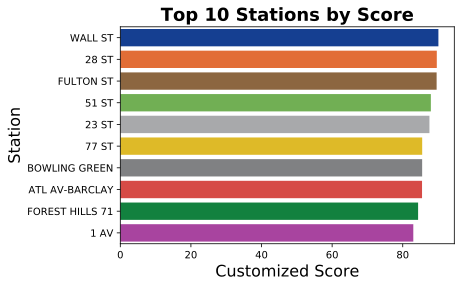

In [434]:
sns.barplot(x ='Recommending_Score',y='STATION',data=df_filt_weekdays_cen_score, orient='h', palette=clrs)
plt.title('Top 10 Stations by Score', weight = 'bold', size=18)
plt.xlabel('Customized Score',size=16)
plt.ylabel('Station',size=16)
plt.savefig('Top 10.svg')

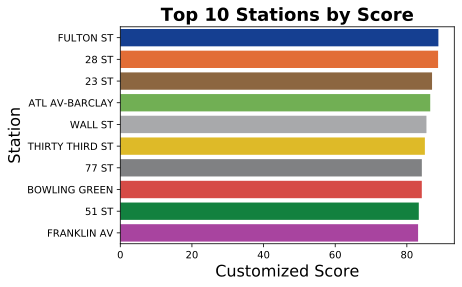

In [435]:
sns.barplot(x ='Recommending_Score',y='STATION',data=df_filt_weekends_cen_score, orient='h', palette=clrs)
plt.title('Top 10 Stations by Score', weight = 'bold', size=18)
plt.xlabel('Customized Score',size=16)
plt.ylabel('Station',size=16)
plt.savefig('Top 10.svg')